## Dependencies

In [108]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Importing the data

Fetch DOW ticker from yfinance

In [109]:
dow = yf.Ticker('^DJI')

Obtain trading history

In [110]:
dow = dow.history(period='max')
dow

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1992-01-02 00:00:00-05:00,3152.100098,3172.629883,3139.310059,3172.399902,23550000,0.0,0.0
1992-01-03 00:00:00-05:00,3172.399902,3210.639893,3165.919922,3201.500000,23620000,0.0,0.0
1992-01-06 00:00:00-05:00,3201.500000,3213.330078,3191.860107,3200.100098,27280000,0.0,0.0
1992-01-07 00:00:00-05:00,3200.100098,3210.199951,3184.479980,3204.800049,25510000,0.0,0.0
1992-01-08 00:00:00-05:00,3204.800049,3229.199951,3185.820068,3203.899902,29040000,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,37349.269531,37534.519531,37268.878906,37385.968750,252970000,0.0,0.0
2023-12-26 00:00:00-05:00,37405.898438,37617.988281,37371.828125,37545.328125,212420000,0.0,0.0
2023-12-27 00:00:00-05:00,37518.621094,37683.699219,37488.601562,37656.519531,245530000,0.0,0.0


Remove old data

## Cleaning data and visualizing

Plot closing price over time

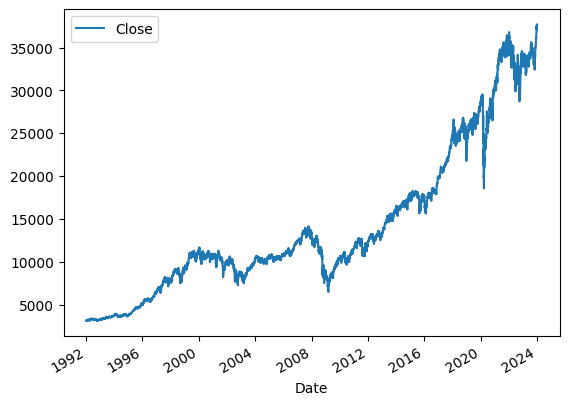

In [111]:
dow.plot.line(y='Close', use_index=True)
plt.show()

Remove unnecessary columns from dataframe

In [112]:
del dow['Dividends']
del dow['Stock Splits']

Create column for stock prices of tomorrow

In [113]:
dow['Tomorrow'] = dow['Close'].shift(-1)
dow.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1992-01-02 00:00:00-05:00,3152.100098,3172.629883,3139.310059,3172.399902,23550000,3201.500000
1992-01-03 00:00:00-05:00,3172.399902,3210.639893,3165.919922,3201.500000,23620000,3200.100098
1992-01-06 00:00:00-05:00,3201.500000,3213.330078,3191.860107,3200.100098,27280000,3204.800049
1992-01-07 00:00:00-05:00,3200.100098,3210.199951,3184.479980,3204.800049,25510000,3203.899902
1992-01-08 00:00:00-05:00,3204.800049,3229.199951,3185.820068,3203.899902,29040000,3209.500000


Create target variables for whether price increases tomorrow

In [114]:
dow['Target'] = (dow['Tomorrow'] > dow['Close']).astype(int)
dow.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1992-01-02 00:00:00-05:00,3152.100098,3172.629883,3139.310059,3172.399902,23550000,3201.500000,1
1992-01-03 00:00:00-05:00,3172.399902,3210.639893,3165.919922,3201.500000,23620000,3200.100098,0
1992-01-06 00:00:00-05:00,3201.500000,3213.330078,3191.860107,3200.100098,27280000,3204.800049,1
1992-01-07 00:00:00-05:00,3200.100098,3210.199951,3184.479980,3204.800049,25510000,3203.899902,0
1992-01-08 00:00:00-05:00,3204.800049,3229.199951,3185.820068,3203.899902,29040000,3209.500000,1


## Training machine learning models

### Functions

Prediction function

In [115]:
def predict(train, test, predictors, model):
    # fit model
    model.fit(X=train[predictors], y=train['Target'])
    # obtain predictions
    predictions = model.predict(X=test[predictors])
    # convert to pd Series
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    # combine predictions with targets
    return pd.concat([test['Target'], predictions], axis=1)

Backtesting to create train/test splits using years up to $i$ to predict on year $i+1$

In [116]:
def backtest(data, model, predictors, start=2500, step=250):
    
    all_predictions = []
    num_rows = data.shape[0]
    
    for i in tqdm(range(start, num_rows, step)):
        # train-test split
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        # obtain predictions
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

Function to return precision, recall and F1

In [117]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def metrics(y_true, y_pred):
    return precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

def print_metrics(precision, recall, f1):
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

In [118]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

### Random forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=80, min_samples_split=100, random_state=1)

predictions = backtest(dow, rf, predictors)

rf_precision, rf_recall, rf_f1 = metrics(y_true=predictions['Target'], y_pred=predictions['Predictions'])
print_metrics(rf_precision, rf_recall, rf_f1)

Precision: 0.5359645887126522
Recall: 0.48922558922558923
F1: 0.5115296602710792
